C:\Users\Nishant Mohan\AppData\Local\Temp\ipykernel_19668\4241766531.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('chess_piece_class

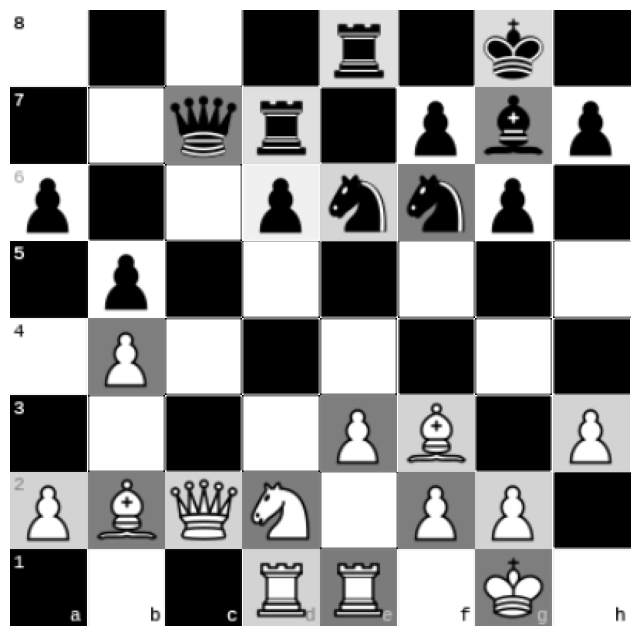

Board Position Array:
['empty', 'empty', 'empty', 'empty', 'black_rook', 'empty', 'black_king', 'empty']
['black_rook', 'empty', 'white_king', 'black_rook', 'empty', 'black_king', 'black_rook', 'black_king']
['black_king', 'empty', 'empty', 'black_king', 'black_knight', 'black_knight', 'black_king', 'empty']
['black_rook', 'black_king', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty']
['empty', 'white_pawn', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty']
['black_rook', 'empty', 'empty', 'empty', 'white_pawn', 'white_bishop', 'empty', 'white_king']
['white_knight', 'white_queen', 'white_queen', 'white_knight', 'empty', 'white_pawn', 'white_king', 'empty']
['black_rook', 'black_pawn', 'empty', 'white_rook', 'white_rook', 'empty', 'white_king', 'empty']
Win Percentage: -1453.15%


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms, models
from PIL import Image

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
# Adjust output layer to match the number of classes (13)
model.fc = nn.Linear(model.fc.in_features, 13)  
model.load_state_dict(torch.load('chess_piece_classifier.pth', map_location=device))
model = model.to(device)
model.eval()

# Define transformations (must match those used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Manually define class names in the same order as in training
class_names = [
    "black_bishop", "black_king", "black_knight", "black_pawn", "black_queen", "black_rook",
    "empty",  # Empty square
    "white_bishop", "white_king", "white_knight", "white_pawn", "white_queen", "white_rook"
]

# Score values for each piece
piece_scores = {
    "white_queen": 9.5, "white_rook": 6, "white_bishop": 3.3, "white_knight": 3, "white_pawn": 0.7, "white_king": 1000,
    "black_queen": -9.5, "black_rook": -6, "black_bishop": -3.3, "black_knight": -3, "black_pawn": -0.7, "black_king": -1000,
    "empty": 0
}

# Function to classify a single square image
def classify_square(square_image, class_names):
    # Convert the grayscale image to 3-channel RGB for model compatibility
    square_image_rgb = cv2.cvtColor(square_image, cv2.COLOR_GRAY2RGB)
    square_image_pil = Image.fromarray(square_image_rgb)
    square_image_transformed = transform(square_image_pil).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(square_image_transformed)
        _, predicted_class = torch.max(output, 1)
    
    # Get class name
    class_name = class_names[predicted_class.item()]
    return class_name

# Function to preprocess the image
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize to standard 8x8 board if necessary
    resized = cv2.resize(gray, (400, 400))  # Example size, adjust as needed
    return resized

# Function to segment the board into 8x8 grid
def segment_board(image):
    board_array = []
    square_size = image.shape[0] // 8  # Assuming an 8x8 square board

    fig, axs = plt.subplots(8, 8, figsize=(8, 8))  # Create an 8x8 grid of subplots

    # Loop through each square
    for row in range(8):
        row_data = []
        for col in range(8):
            # Extract the square image
            square = image[row * square_size:(row + 1) * square_size, 
                           col * square_size:(col + 1) * square_size]

            # Resize each square image for better display
            square_resized = cv2.resize(square, (50, 50))

            # Display the square on the grid
            axs[row, col].imshow(square_resized, cmap='gray')  # Display as grayscale
            axs[row, col].axis('off')  # Hide axes for a cleaner look

            # Predict the piece in the square (if any)
            piece = classify_square(square_resized, class_names)
            row_data.append(piece)
        board_array.append(row_data)

    plt.subplots_adjust(wspace=0, hspace=0)  # Remove space between images
    plt.show()
    return board_array

# Function to calculate win percentage
def calculate_win_percentage(board_array):
    total_score = 0
    for row in board_array:
        for piece in row:
            total_score += piece_scores.get(piece, 0)

    # Calculate win percentage based on score difference
    if -0.5 <= total_score <= 0.5:
        win_percentage = 50  # Advantage is equal
    elif total_score > 0.5:
        win_percentage = 50 + (total_score * 0.5)  # Example scale for winning side
    else:
        win_percentage = 50 - (abs(total_score) * 0.5)

    return win_percentage

# Main function to convert an image into a board array
def convert_image_to_array(image_path):
    # Preprocess and segment the board
    processed_image = preprocess_image(image_path)
    board_array = segment_board(processed_image)
    
    # Optional: Flatten the array if needed for your model
    flattened_board_array = [piece for row in board_array for piece in row]
    
    return board_array

# Example usage
image_path = r'C:\Users\Nishant Mohan\Desktop\iLLogical\Data\train\11161.png'
board_array = convert_image_to_array(image_path)

print("Board Position Array:")
for row in board_array:
    print(row)

# Calculate win percentage
win_percentage = calculate_win_percentage(board_array)
print(f"Win Percentage: {win_percentage}%")
